In [3]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-05-04   AAPL  164.909744  165.789993  167.039993  164.309998   
1         2023-05-04   GOOG  105.209999  105.209999  106.300003  104.699997   
2         2023-05-04   MSFT  302.923798  305.410004  307.760010  303.399994   
3         2023-05-04   NFLX  320.779999  320.779999  323.609985  317.950012   
4         2023-05-04   TSLA  161.199997  161.199997  162.949997  159.649994   

Attribute        Open      Volume  
0          164.889999  81235400.0  
1          106.160004  19780600.0  
2          306.239990  22519900.0  
3          319.010010   3879700.0  
4          162.710007  95108500.0  


#### Data Transformation

In [4]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-05-04   AAPL  164.909744  165.789993  167.039993  164.309998  164.889999   
2023-05-04   GOOG  105.209999  105.209999  106.300003  104.699997  106.160004   
2023-05-04   MSFT  302.923798  305.410004  307.760010  303.399994  306.239990   
2023-05-04   NFLX  320.779999  320.779999  323.609985  317.950012  319.010010   
2023-05-04   TSLA  161.199997  161.199997  162.949997  159.649994  162.710007   

Attribute       Volume  
Date                    
2023-05-04  81235400.0  
2023-05-04  19780600.0  
2023-05-04  22519900.0  
2023-05-04   3879700.0  
2023-05-04  95108500.0  


## Anomaly Detection

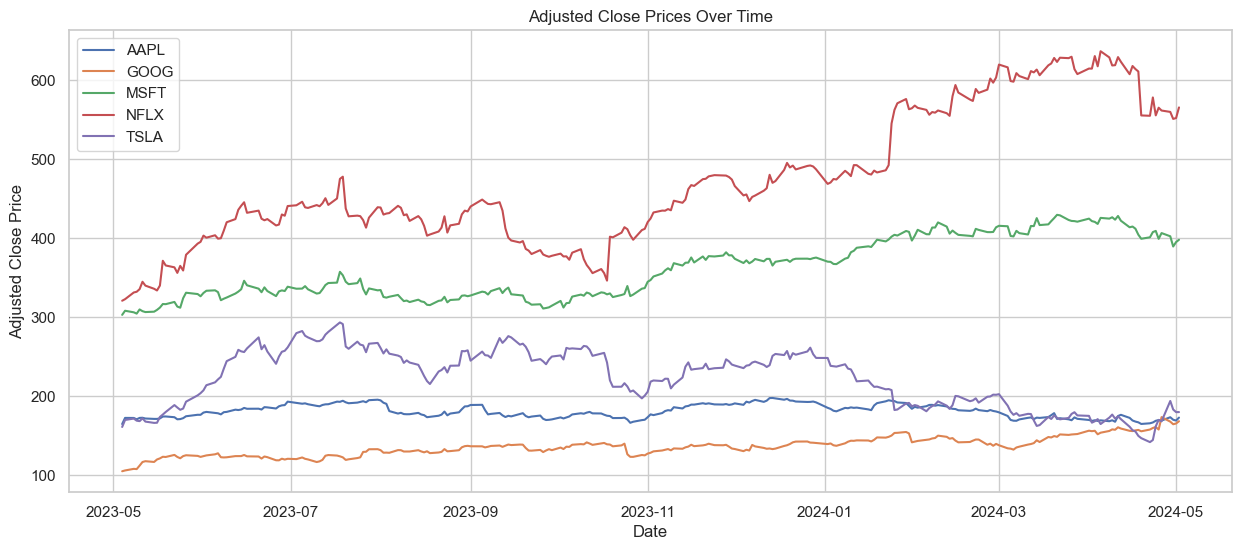

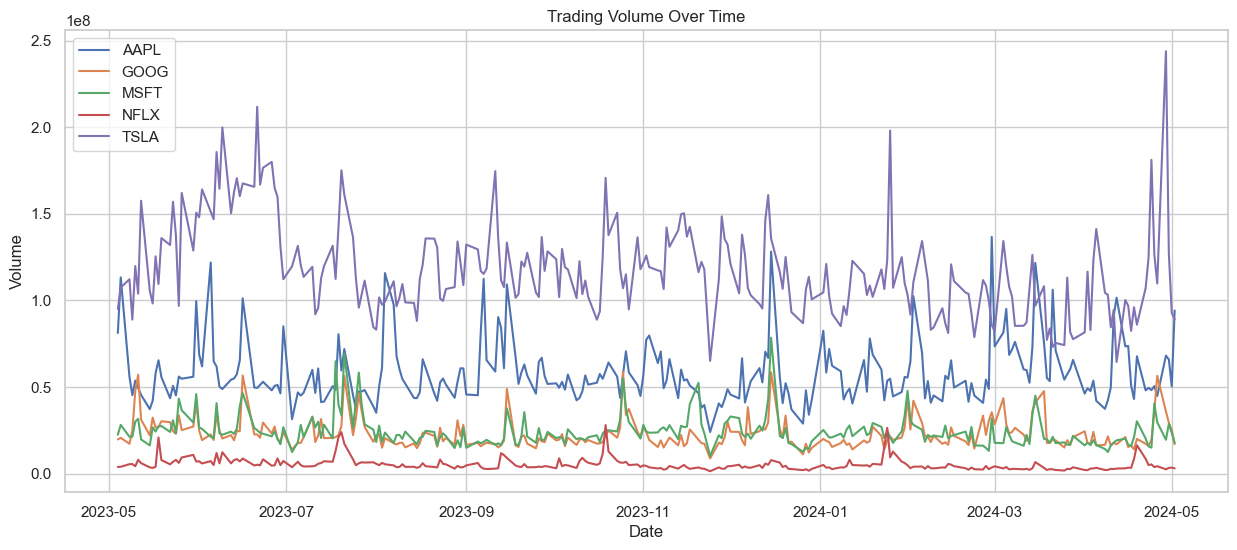

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

##### GOOG has the highest price and shows an uptrend, while TSLA and AAPL show steady increases. MSFT and NFLX have lower prices, with NFLX fluctuating but mostly flat. AAPL and TSLA have the highest trading volumes, with TSLA showing spikes. MSFT and NFLX have lower trading volumes, possibly due to earnings reports or market-moving events.

##### For the task of stock market anomaly detection, we can use the Z-score method, which identifies anomalies based on how many standard deviations away a data point is from the mean.

In [6]:
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-05-04   GOOG  105.209999  105.209999  106.300003  104.699997  106.160004   
2023-05-05   GOOG  106.214996  106.214996  106.440002  104.738998  105.320000   
2023-05-08   GOOG  108.239998  108.239998  108.419998  105.790001  105.794998   
2023-05-09   GOOG  107.940002  107.940002  110.595001  107.724998  108.779999   
2023-05-10   GOOG  112.279999  112.279999  113.510002  108.480003  108.550003   

Attribute       Volume   Z-score  
Date                              
2023-05-04  19780600.0 -2.597748  
2023-05-05  20705300.0 -2.513729  
2023-05-08  17266000.0 -2.344436  
2023-05-09  24782400.0 -2.369516  
2023-05-10  47533500.0 -2.006686  


In [7]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-05-05   AAPL  172.648453  173.570007  174.300003  170.759995  170.979996   
2023-05-31   AAPL  176.552780  177.250000  179.350006  176.759995  177.330002   
2023-06-05   AAPL  178.873611  179.580002  184.949997  178.039993  182.630005   
2023-06-16   AAPL  184.192612  184.919998  186.990005  184.270004  186.729996   
2023-08-04   AAPL  181.274155  181.990005  187.380005  181.919998  185.520004   

Attribute        Volume   Z-score  
Date                               
2023-05-05  113316400.0  3.109444  
2023-05-31   99625300.0  2.339211  
2023-06-05  121946500.0  3.594955  
2023-06-16  101235600.0  2.429803  
2023-08-04  115799700.0  3.249149  


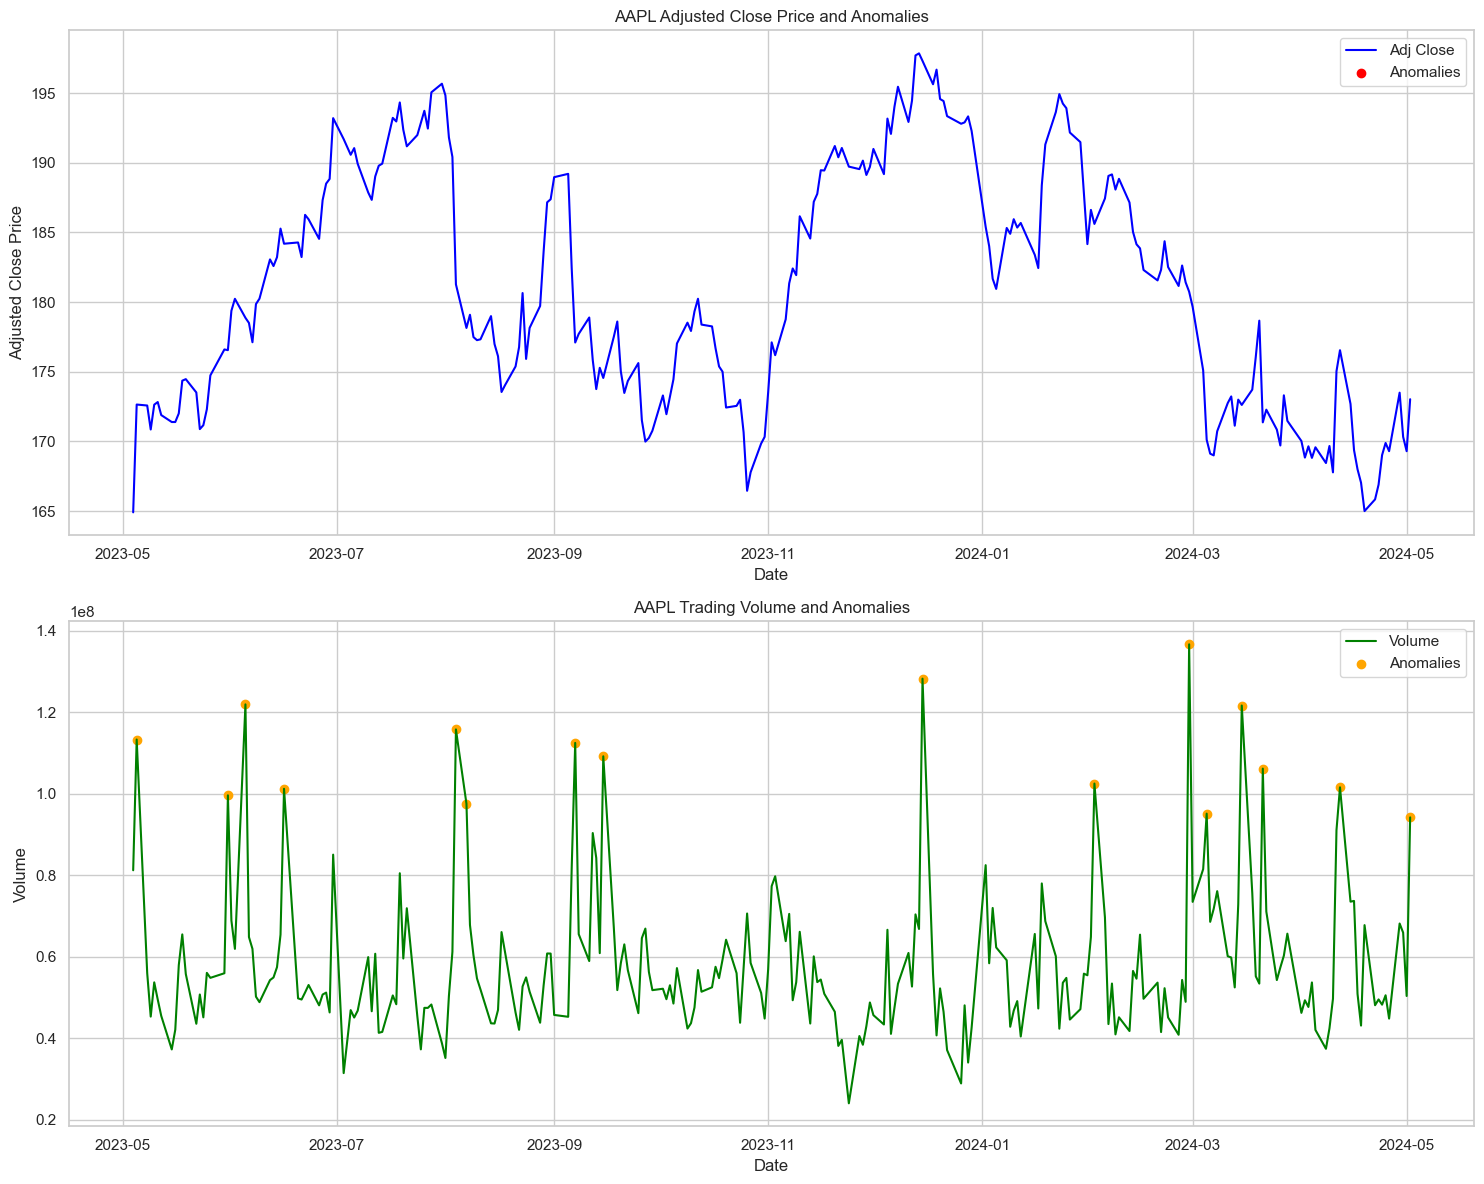

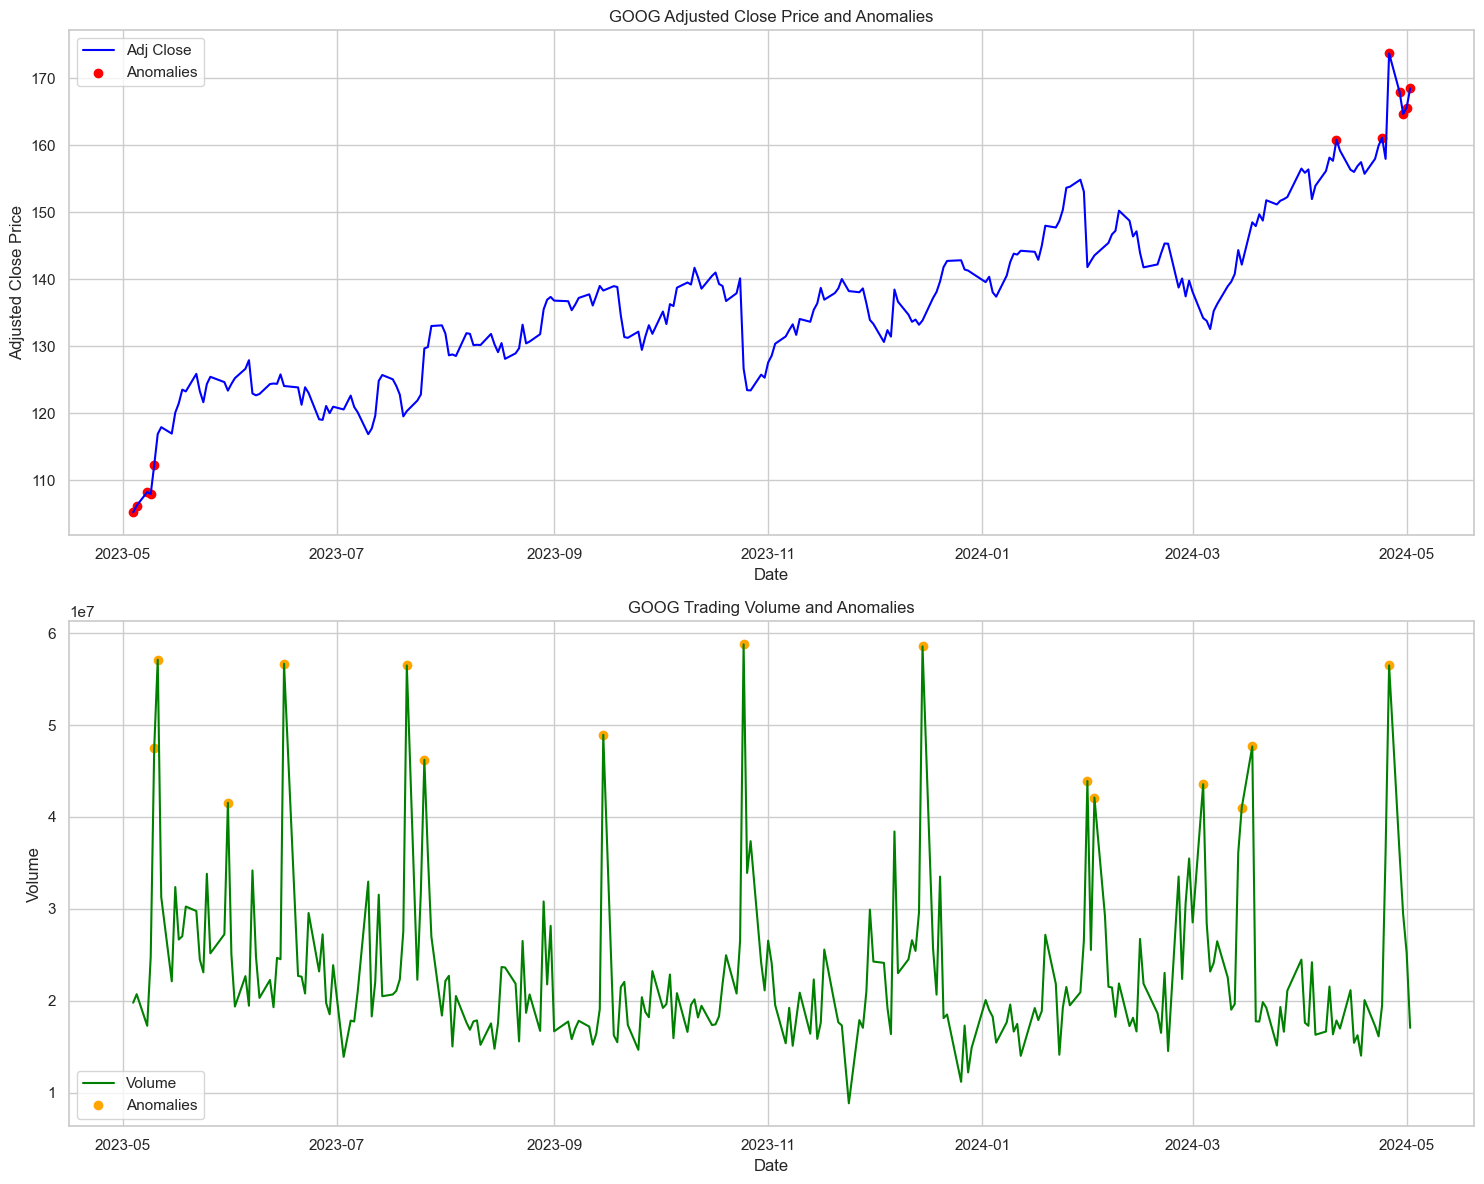

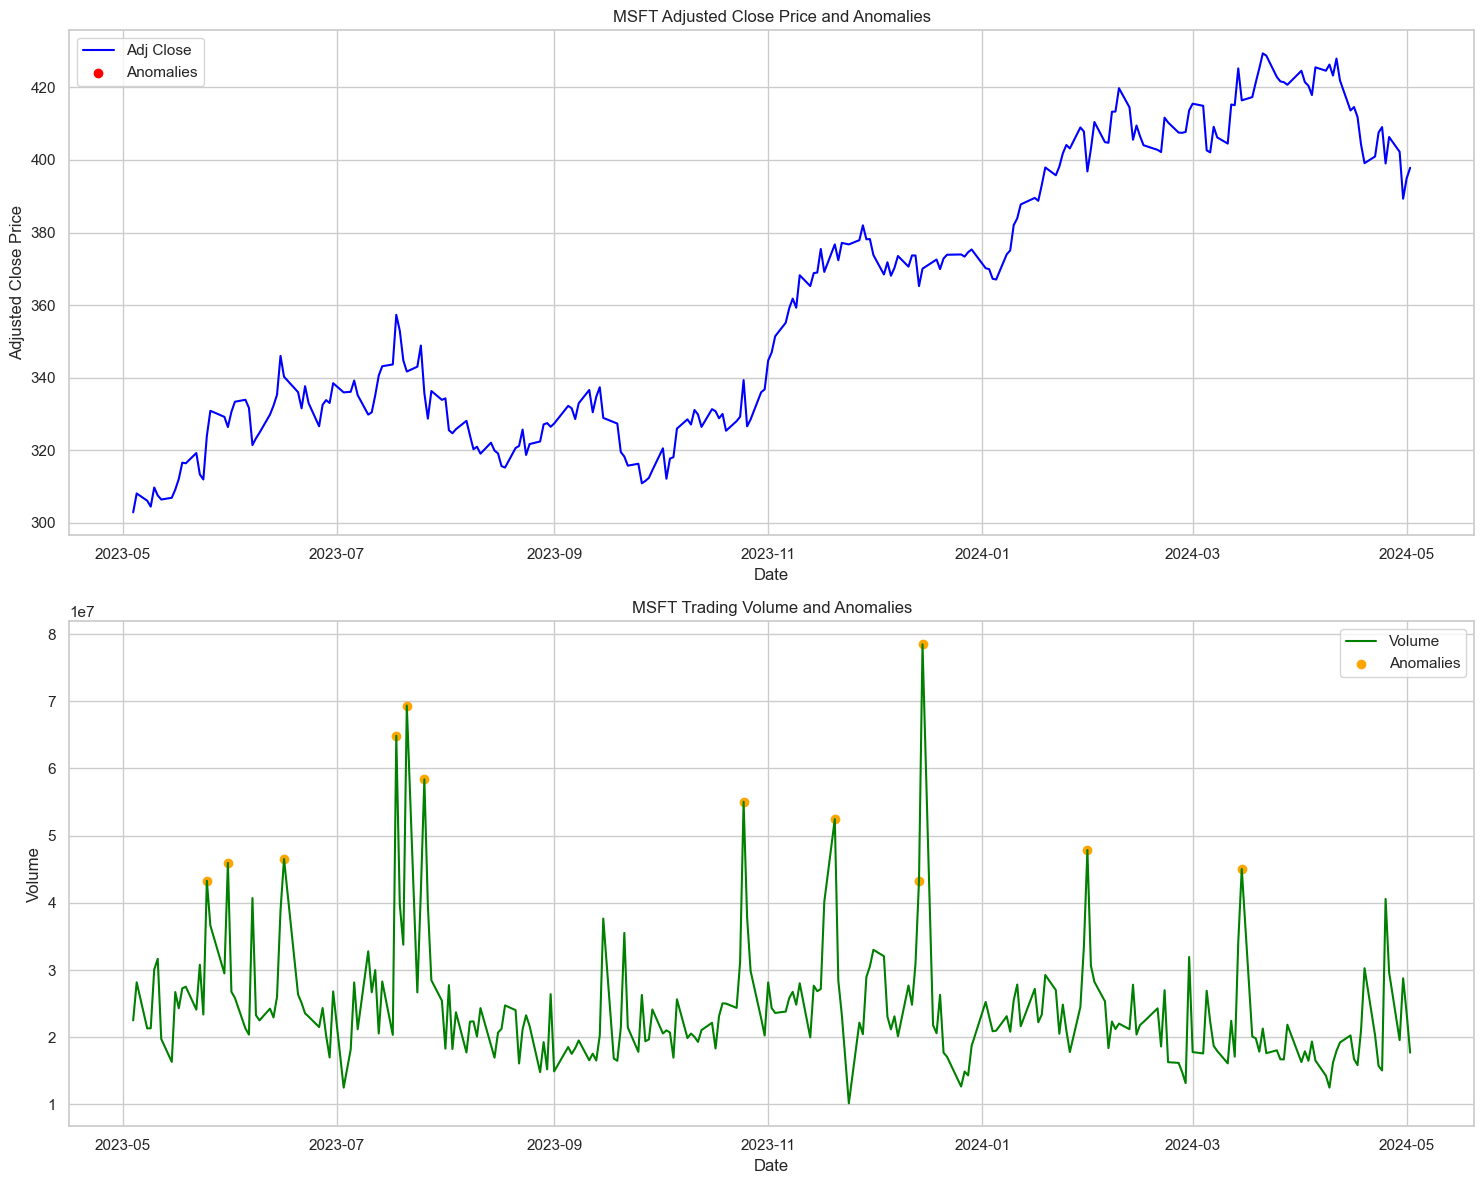

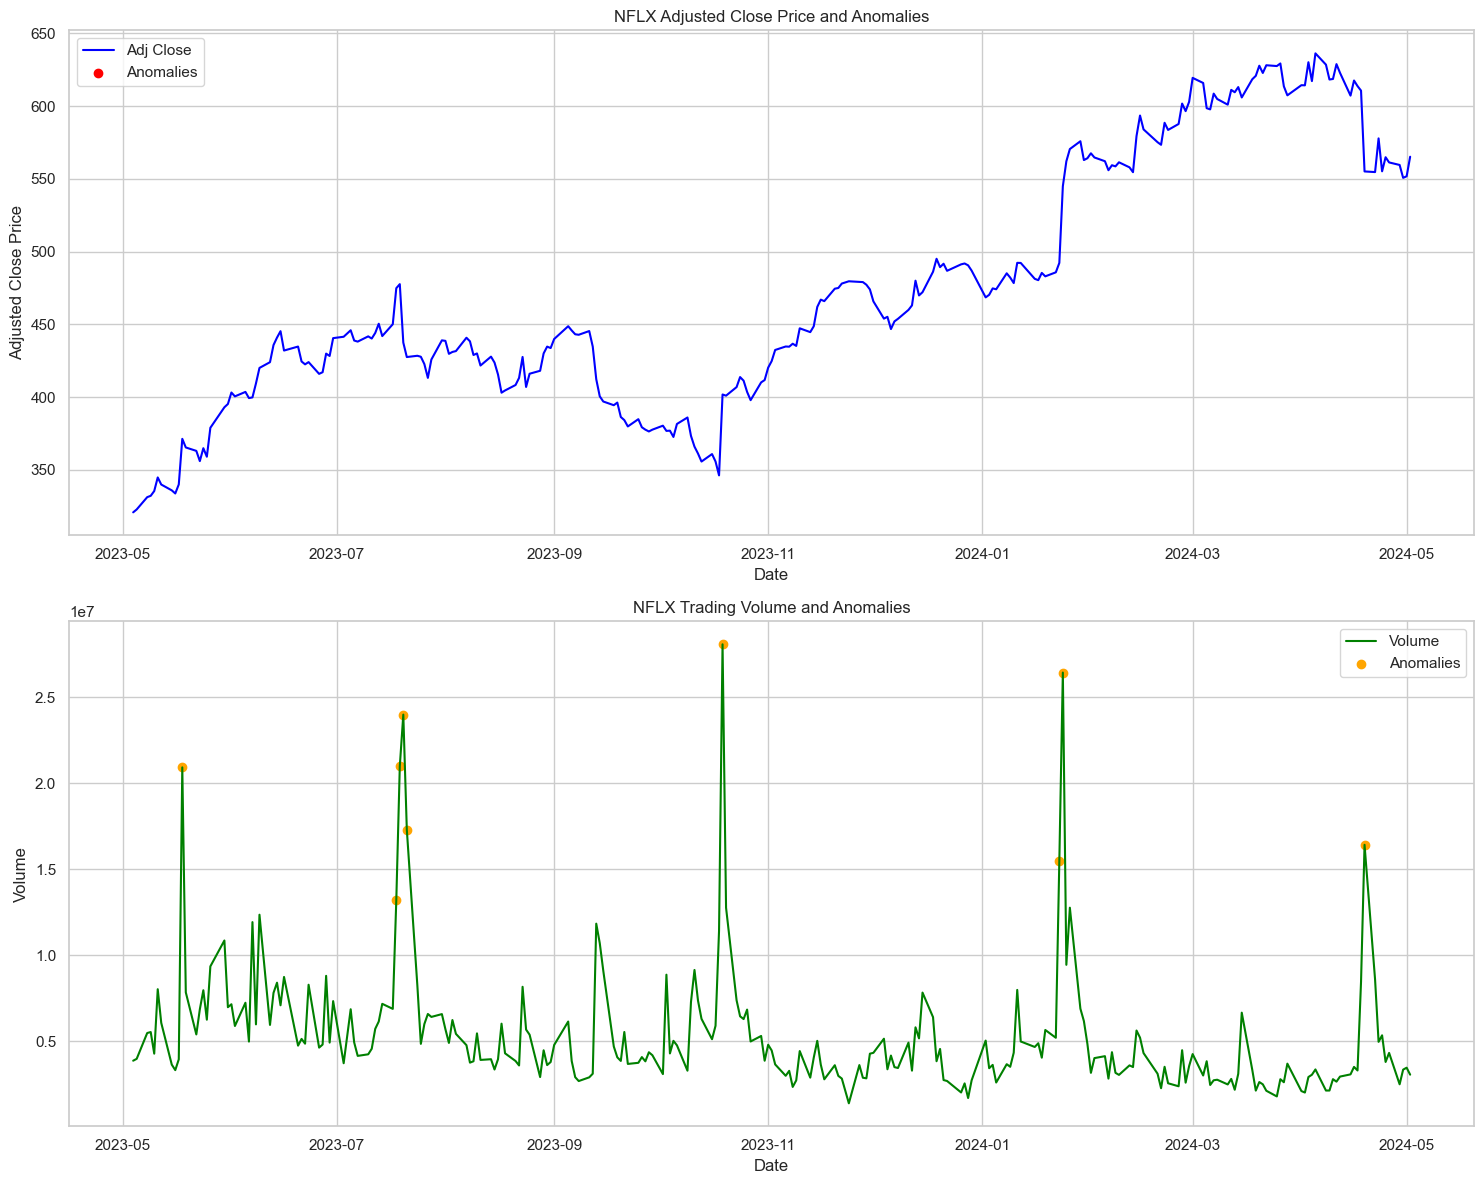

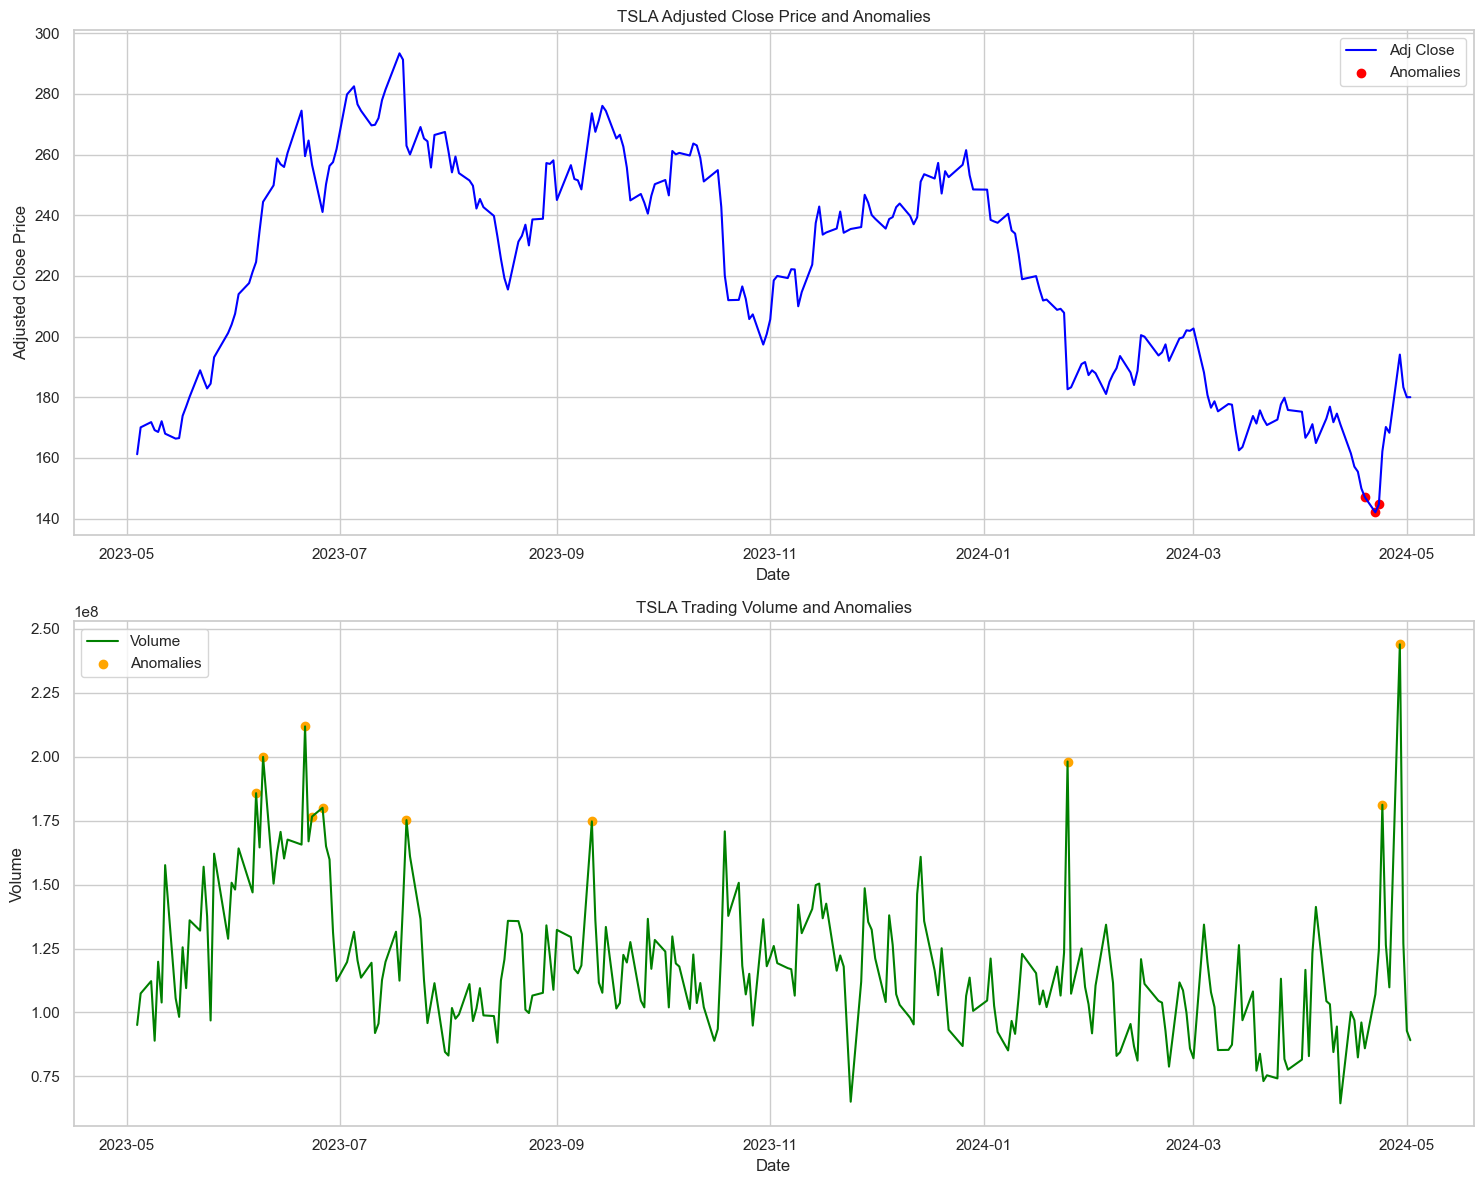

In [10]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

##### Anomalies are marked in red and represent significant deviations from the typical price range. These could correspond to days with unexpected news, earnings reports, or market shifts.
##### Anomalies in trading volume are marked in orange and indicate days with exceptionally high or low trading activity compared to the norm. Such spikes could be due to market events, announcements, or other factors influencing trader behaviour.

#### Correlation in the anomalies of all the companies:

In [11]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly           Volume Anomaly            \
Ticker                                GOOG      TSLA           AAPL      GOOG   
                  Ticker                                                        
Adj Close Anomaly GOOG            1.000000 -1.000000       0.258199  0.258199   
                  TSLA           -1.000000  1.000000      -0.258199 -0.258199   
Volume Anomaly    AAPL            0.258199 -0.258199       1.000000  0.065653   
                  GOOG            0.258199 -0.258199       0.065653  1.000000   
                  MSFT                 NaN       NaN      -0.027995  0.426401   
                  NFLX           -1.000000  1.000000      -0.371391 -0.235702   
                  TSLA            0.258199 -0.258199      -0.397033 -0.377964   

                                                        
Ticker                        MSFT      NFLX      TSLA  
                  Ticker                                
Adj Close Anomaly 

##### AAPL has a low positive correlation with GOOG and a negative correlation with NFLX in terms of adjusted close price anomalies. It suggests that price movements in AAPL have some level of simultaneous occurrence with GOOG but move inversely with NFLX. On the other hand, GOOG and NFLX show a strong negative correlation, indicating that when one experiences an anomalous price increase (or decrease), the other tends to move in the opposite direction.

##### In trading volumes, GOOG shows a positive correlation with MSFT in trading volume anomalies, suggesting that these companies might have simultaneous unusual trading activities. AAPL’s volume anomalies have a negative correlation with other companies like NFLX and TSLA, indicating that when AAPL experiences unusual trading volume, these companies tend to have opposite anomalies in their trading volumes.

## Analyzing the Risk of Anomalies


#####  For this task, we can consider the frequency and magnitude of these anomalies. A stock could be considered more risky if it has frequent and large anomalies in its price or volume.


##### For simplicity, we could average the absolute Z-scores of anomalies for each stock and then normalize these scores across all stocks to get a risk rating:

In [13]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    NaN
GOOG    1.0
MSFT    NaN
NFLX    NaN
TSLA    0.0
Name: Z-score, dtype: float64


##### Interpretation:
AAPL: Has a risk rating of approximately 0.17. It suggests that Apple’s stock shows some level of risk due to anomalies, but it is relatively moderate compared to others like NFLX.

GOOG: With a risk rating of around 0.06, GOOG appears to be less risky compared to AAPL. It indicates fewer or less significant anomalies in its trading data.

MSFT: Shows a risk rating of 0.00, indicating the least risk among the stocks listed. It suggests that Microsoft had the fewest and smallest anomalies in its price and volume data.

NFLX: Has the highest risk rating at 1.00. It indicates that Netflix is the most risky among these stocks, with the most frequent and largest anomalies detected.

TSLA: The NaN value suggests that it did not have detectable anomalies in the period analyzed.

#### Anomalies in the stock market are important because they can indicate opportunities or risks. For example, a sudden spike in a stock’s price could be due to positive news about the company or its industry, which signals a potential investment opportunity. Conversely, an unexpected price drop could warn of underlying issues or market sentiment changes, which signals a risk that investors may need to manage.